In [1]:
df <- read.csv(file = "deptos_agrupados2.csv", sep=',', header = T)

In [2]:
df$var2008 <- NULL
df$var2009 <- NULL
df$var2010 <- NULL
df$var2011 <- NULL
df$var2012 <- NULL
df$var2013 <- NULL
df$var2014 <- NULL
df$var2015 <- NULL

In [3]:
df$X.1 <- NULL
df$X <- NULL

In [4]:
df <- df[!is.na(df$varprom),]

In [5]:
df <- df[order(df$varprom),]

In [6]:
p <- (nrow(df)*10)/100

In [7]:
df$varprom <- 0
for (i in seq(from = (nrow(df) - p),to = nrow(df))){
    df$varprom[i] <- 1
}

In [8]:
table(df$varprom)


    0     1 
20465  2275 

### Construimos el modelo usando XGBoost

Paso 1: Cargamos las librerías

In [9]:
#install.packages("xgboost")
require(xgboost)

Loading required package: xgboost


In [10]:
library(data.table)

Paso 2: Cargamos los datasets train y test

In [11]:
df_train <- df[df$ANIO != 2015,]
df_test <- df[df$ANIO == 2015,]

In [12]:
df_train$ANIO <- NULL
df_test$ANIO <- NULL

In [13]:
#convert data frame to data table
setDT(df_train) 
setDT(df_test)

In [14]:
df_train2 <- scale(df_train[,-c("varprom"),with=F])
df_test2 <- scale(df_test[,-c("varprom"),with=F])

In [15]:
#using one hot encoding 
tr_label <- df_train$varprom
ts_label <- df_test$varprom
new_tr <- model.matrix(~.+0,data = as.data.frame(df_train2)) 
new_ts <- model.matrix(~.+0,data = as.data.frame(df_test2))

In [16]:
#preparing matrix 
dtrain <- xgb.DMatrix(data = new_tr,label = tr_label) 
dtest <- xgb.DMatrix(data = new_ts,label = ts_label)

In [27]:
#default parameters
params <- list(booster = "gbtree", objective = "binary:logistic", eval_metric = "auc", eval_metric = "logloss", eta=0.3, max_depth=20, early_stopping_round = 10)

In [28]:
xgbcv <- xgb.cv( params = params, data = dtrain, nrounds = 1000, nthread = 2,nfold = 5)

[1]	train-auc:0.871953+0.004000	train-logloss:0.489683+0.001932	test-auc:0.762500+0.012668	test-logloss:0.511178+0.002265 
[2]	train-auc:0.935242+0.007540	train-logloss:0.369213+0.001793	test-auc:0.818623+0.009111	test-logloss:0.406887+0.001027 
[3]	train-auc:0.970139+0.003037	train-logloss:0.286365+0.002360	test-auc:0.856831+0.011580	test-logloss:0.337851+0.002103 
[4]	train-auc:0.985349+0.002833	train-logloss:0.227418+0.003357	test-auc:0.878968+0.013227	test-logloss:0.290427+0.003379 
[5]	train-auc:0.992203+0.001684	train-logloss:0.184157+0.003536	test-auc:0.896534+0.011537	test-logloss:0.256880+0.004922 
[6]	train-auc:0.996322+0.000680	train-logloss:0.151065+0.002372	test-auc:0.909452+0.009746	test-logloss:0.232326+0.004756 
[7]	train-auc:0.998220+0.000231	train-logloss:0.125018+0.003147	test-auc:0.917358+0.011456	test-logloss:0.212777+0.006402 
[8]	train-auc:0.999161+0.000207	train-logloss:0.103880+0.002143	test-auc:0.929280+0.009205	test-logloss:0.196107+0.005311 
[9]	train-auc:0.

In [29]:
#first default - model training
xgb1 <- xgb.train (params = params, data = dtrain, nrounds = 1000, nthread = 2, watchlist = list(val=dtest,train=dtrain), early_stopping_round = 10)
#model prediction
xgbpred <- predict (xgb1,dtest)
xgbpred <- ifelse (xgbpred > 0.5,1,0)

[1]	val-auc:0.753762	val-logloss:0.514910	train-auc:0.901278	train-logloss:0.483885 
Multiple eval metrics are present. Will use train_logloss for early stopping.
Will train until train_logloss hasn't improved in 10 rounds.

[2]	val-auc:0.800560	val-logloss:0.415301	train-auc:0.941257	train-logloss:0.364053 
[3]	val-auc:0.829390	val-logloss:0.348084	train-auc:0.973024	train-logloss:0.280957 
[4]	val-auc:0.857907	val-logloss:0.300458	train-auc:0.985781	train-logloss:0.219662 
[5]	val-auc:0.874937	val-logloss:0.269395	train-auc:0.993087	train-logloss:0.177203 
[6]	val-auc:0.888750	val-logloss:0.246097	train-auc:0.996173	train-logloss:0.144306 
[7]	val-auc:0.894512	val-logloss:0.229987	train-auc:0.997590	train-logloss:0.119696 
[8]	val-auc:0.911651	val-logloss:0.211210	train-auc:0.999253	train-logloss:0.097795 
[9]	val-auc:0.920288	val-logloss:0.199673	train-auc:0.999419	train-logloss:0.081912 
[10]	val-auc:0.925324	val-logloss:0.191565	train-auc:0.999623	train-logloss:0.069630 
[11]	val-

In [30]:
as.data.frame(table(xgbpred))

xgbpred,Freq
0,2305
1,158


In [21]:
#install.packages("e1071")
library(caret)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: lattice
Loading required package: ggplot2


In [31]:
#confusion matrix
confusionMatrix (xgbpred, ts_label)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2217   88
         1    6  152
                                          
               Accuracy : 0.9618          
                 95% CI : (0.9535, 0.9691)
    No Information Rate : 0.9026          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.744           
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9973          
            Specificity : 0.6333          
         Pos Pred Value : 0.9618          
         Neg Pred Value : 0.9620          
             Prevalence : 0.9026          
         Detection Rate : 0.9001          
   Detection Prevalence : 0.9359          
      Balanced Accuracy : 0.8153          
                                          
       'Positive' Class : 0               
                                          

In [24]:
#install.packages("pROC")
library(pROC)

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



In [32]:
auc(ts_label, xgbpred)

Area under the curve: 0.8153

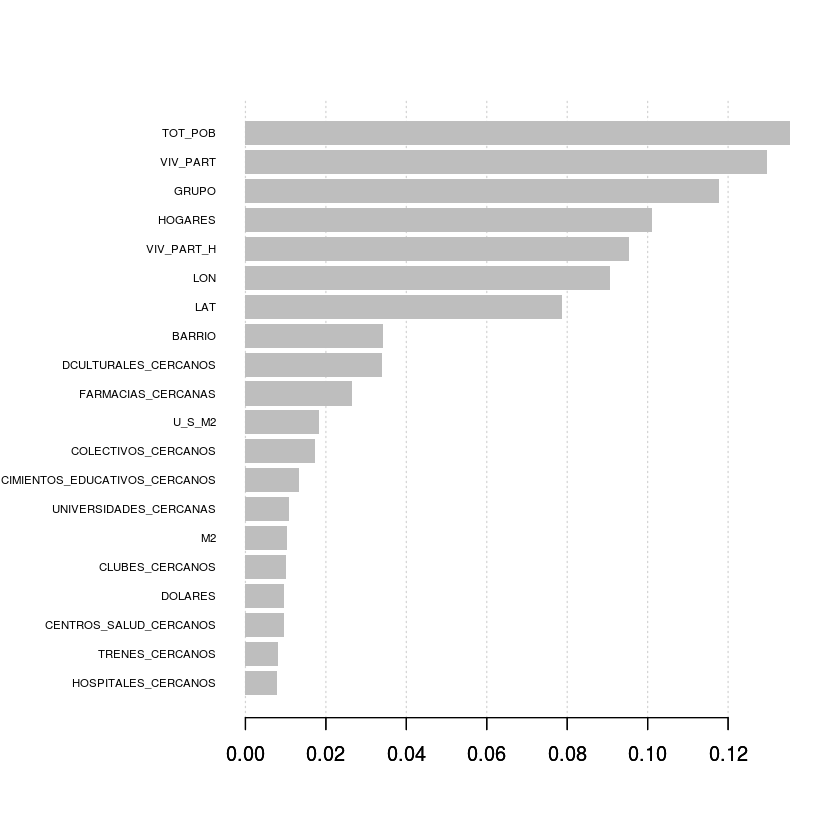

In [26]:
#view variable importance plot
mat <- xgb.importance (feature_names = colnames(new_tr),model = xgb1)
xgb.plot.importance (importance_matrix = mat[1:20])